# Corso di Analisi Dati in Fisica Subnucleare
## Esame del 15 settembre 2021

## Tema: La tecnica bootstrap per la stima dell'errore statistico
In questo esercizio metteremo in pratica la tecnica del bootstrap per valutare l'errore statistico in modo indipendente dalla curvatura della funzione di verosimiglianza.

La tecnica del bootstrap consiste nel *ricampionare* il set di dati iniziale permettendo elementi ripetuti per poi ripetere la procedura di fit su ciascuno dei set di dati così ottenuti.

Si dimostra che il valore ottenuto dal fit di ciascun set di dati ricampionati fluttua con una deviazione standard pari all'incertezza statistica sul valore stesso.

Questa proprietà permette di studiare l'incertezza statistica in casi complessi in cui la funzione verosimiglianza è complicata, per esempio, dalla vicinanza di regioni dello spazio dei parametri "non fisiche".

In questo esercizio però consideremo un caso semplice per poter confrontare l'errore statistico ottenuto dal fit con l'errore ottenuto dal bootstrap.

> **Nota**: la risposta a ciascuna domanda può essere ottenuta in 15 righe di codice o meno. Benché non ci sia un premio per soluzioni più brevi, se la soluzione che avete in mente richiede molto più codice, allora sappiate che sicuramente esiste un modo più semplice per risolvere il problema.

## Il problema

In un esperimento di fisica di alte energie ad un collisionatore vengono ricostruite coppie di fotoni e ne viene calcolata la massa.
Il dataset è stato salvato in formato root e reso disponibile all'indirizzo:

In [ ]:
!pip install --upgrade uproot iminuit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot

## Caricare il dataset

Il dataset è costituito da un `TTree` con una sola branch chiamata `x` che contiene la massa invariante della coppia di fotoni.

Utilizzare `uproot` per scaricare il dataset e convertirlo in un array di `numpy`.

In [ ]:
!wget http://pandora.infn.it/public/ab88e4/dl/data.root -O "data.root" &> /dev/null
mass = uproot.open("data.root")['sig'].arrays(library='numpy')['x']

## Analisi esplorativa
Costruire l'istogramma della massa invariante.

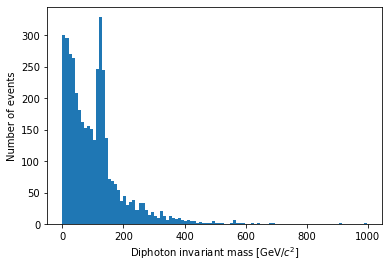

In [ ]:
plt.hist(mass, bins=100)
plt.xlabel ("Diphoton invariant mass [GeV/$c^2$]")
plt.ylabel ("Number of events")
plt.show()

Scegliere una finestra di massa invariante appropriata per poter eseguire un fit: abbastanza stretta da poter approssimare la distribuzione del fondo con una retta e abbastanza larga da includere regioni senza alcun contributo di segnale.

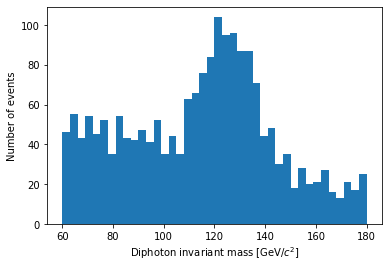

In [ ]:
sbox = (60, 180)
plt.hist(mass, bins=np.linspace(sbox[0], sbox[1], (sbox[1]-sbox[0])//3+1))

plt.xlabel ("Diphoton invariant mass [GeV/$c^2$]")
plt.ylabel ("Number of events")
plt.show()

Contare il numero `nTot` di eventi all'interno della finestra di massa invariante individuata.

In [ ]:
nTot = np.count_nonzero ( (mass > sbox[0]) & (mass < sbox[1]) )

## Fit alla massa invariante
Costruire un fit di massima verosimiglianza estesa (extended maximum likelihood) del dataset.
Ad esempio sovrapponendo un picco gaussiano ad un fondo lineare o esponenziale, normalizzando la componente di fondo numericamente oppure analiticamente.

In [ ]:
class Model:
    def __init__ (self, x, range_=(60,180)):
        self.x = x[(x > range_[0]) & (x<range_[1])]
        self.range = range_

    def signal (self, x, x0, sigma):
        return 1./np.sqrt(2*np.pi)/sigma * np.exp (-0.5*((x-x0)/sigma)**2)

    def _background (self, x, slope):
        return 1 + slope * x

    def background (self, x, slope):
        xs = np.linspace(self.range[0], self.range[1], 1000)
        return self._background(x, slope) / np.mean (self._background(xs,slope)) / (self.range[1] - self.range[0])

    def model (self, x, ns, nb, x0, sigma, slope):
        return (ns * self.signal(x, x0, sigma) + nb * self.background(x, slope))/(ns + nb)

    def loss (self, ns, nb, x0, sigma, slope):
        return ns + nb - np.sum(np.log((ns+nb) * self.model(self.x, ns, nb,  x0, sigma, slope)))

Verificare che ciascuna componente del modello statistico è normalizzata singolarmente, e che è normalizzata la somma delle componenti.

In [ ]:
model = Model(mass, sbox)
xs = np.linspace(60, 180, 1000)
print ("Norm signal: ", np.trapz (model.signal(xs, 120, 10), xs))
print ("Norm background: ", np.trapz (model.background(xs, -2), xs))
print ("Norm all: ", np.trapz (model.model(xs, 1000, 2000, 120, 10, -2), xs))

Norm signal:  0.9999999980259482
Norm background:  1.0
Norm all:  0.9999999993419827


Massimizzare la verosimiglianza con iminuit e ottenere l'incertezza statistica sul valore centrale della gaussiana che modellizza il picco.

In [ ]:
from iminuit import Minuit
m = Minuit (model.loss, ns=0.5 * nTot, nb=0.5 * nTot, x0=125, sigma=10, slope=-1e-4)
m.errordef = 0.5
m.errors = (1, 1, 1, 0.1, 1e-4)
fit_results = m.migrad()

fit_results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3608                      │              Nfcn = 152              │
│ EDM = 2.94e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │    560    │    40     │            │            │         │         │       │
│ 1 │ nb    │  1.36e3   │  0.05e3   │            │            │         │         │       │
│ 2 │ x0    │   125.6   │    0.7    │            │            │         │         │       │
│ 3 │ sigma │    9.5    │    0.6    │            │            │         │         │       │
│ 4 │ slope │ -4.20e-3  │  0.18e-3  │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │        ns        nb        x0     sigma     slope │
├───────┼───────────────────────────────────────────────────┤
│    ns │  1.49e+03      -930     -1.51      11.3 -0.000818 │
│    nb │      -930  2.29e+03      1.51     -11.2  0.000818 │
│    x0 │     -1.51      1.51     0.445    -0.026 -2.03e-05 │
│ sigma │      11.3     -11.2    -0.026     0.392 -1.16e-05 │
│ slope │ -0.000818  0.000818 -2.03e-05 -1.16e-05  3.29e-08 │
└───────┴───────────────────────────────────────────────────┘

Costruire un grafico che mostri la sovrapposizione dell'istogramma e del modello statistico ottimizzato con il fit.

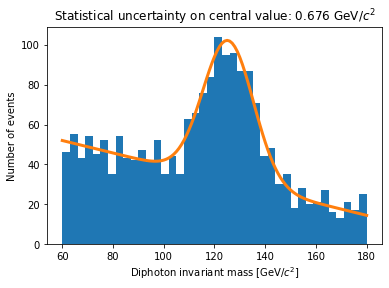

In [ ]:
xs = np.linspace (60, 180, 121)

pdf = model.model (xs, *fit_results.values)
plt.hist(mass, bins=np.linspace(60,180,41))
binw = (180 - 60)/40

plt.plot (xs, pdf*np.count_nonzero((mass > 60) & (mass < 180))*binw, linewidth=3)
plt.title (f"Statistical uncertainty on central value: {fit_results.errors['x0']:.3f} GeV/$c^2$")
plt.xlabel ("Diphoton invariant mass [GeV/$c^2$]")
plt.ylabel ("Number of events")
plt.show()

## Bootstrap: *costruzione e fit dei dataset ricampionati*

Utilizzare la funzione `np.random.choice` per ricampionare il vettore di dati ammettendo ripetizioni.
Ad esempio se il vettore che contiene l'intero dataset è
```
x = {7,9,8}
```
`np.random.choice` genera un campione  ottenuto scegliendo elementi casualmente all'interno di `x`
```
np.random.choice(x, len(x)) -> {9,7,7}
```

Fittare il dataset ricampionato con il modello definito sopra e **SE LA PROCEDURA DI MINIMIZZAZIONE HA AVUTO SUCCESSO** salvare il risultato per il valore centrale del picco gaussiano in una lista.

Ripetere la generazione casuale del campione ed il fit per 500 volte, utilizzando un ciclo `for`.

Alla fine avremo ottenuto una lista di alcune centinaia di valori centrali del picco ottenuti in fit indipendenti a dataset ottenuti ricampionando il dataset originale.

In [ ]:
toy_results = []

for iToy in range(500):
    toy_model = Model (np.random.choice(mass, len(mass)))

    m = Minuit (toy_model.loss, ns=0.5 * nTot, nb=0.5 * nTot, x0=125, sigma=10, slope=-1e-3)
    m.errordef = 0.5

    m.errors = (100, 100, 1, 0.1, 1e-3)
    fit_results = m.migrad()

    if fit_results.valid:
        toy_results.append (fit_results.values['x0'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


Costruire l'istogramma dei risultati contenuti nella lista costruita nel passaggio precedente e
misurarne la deviazione standard.

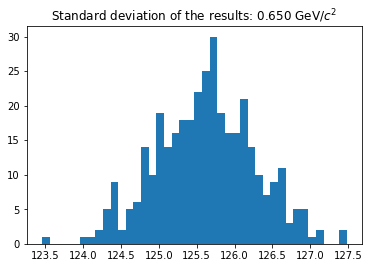

In [ ]:
plt.hist(toy_results, bins = 40)
plt.title (f"Standard deviation of the results: {np.std(toy_results):.3f} GeV/$c^{2}$")
plt.show()

## Conclusione
Confrontando la deviazione standard ottenuta nel passaggio precedente con la stima ottenuta con l'algoritmo HESSE di `iminuit` dovreste notare che i valori sono tra loro compatibili entro un errore del 10%.

Il metodo bootstrap è usato molto spesso per verificare le stime degli errori statistici con un metodo indipendente dallo studio analitico della funzione di verosimiglianza.